# Simulate training from notebook

In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import sys

from collections import Counter

Read the raw data and plot it, to check that everything work as expected

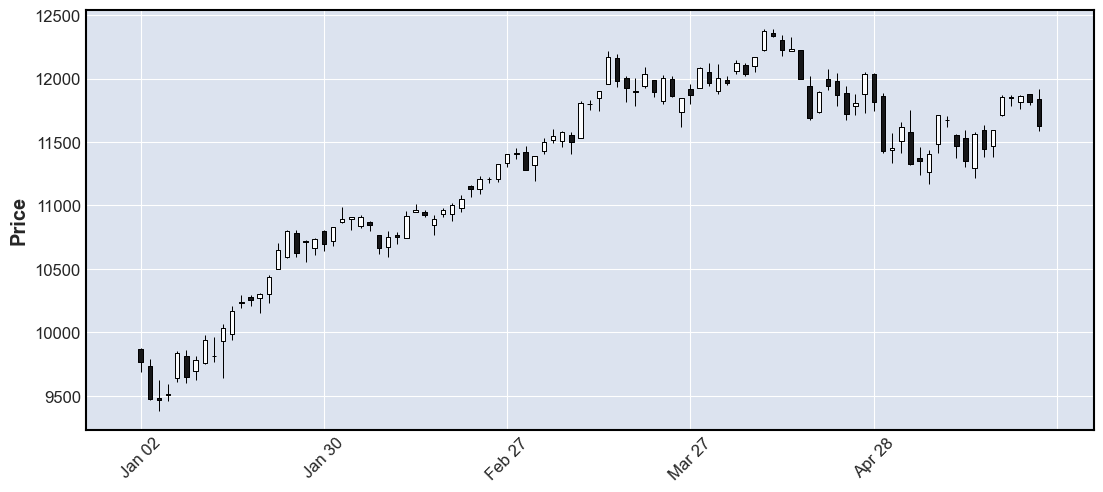

In [2]:
url = '../data/^GDAXI/dax_100.csv'
ohlc = pd.read_csv(url)

# Set the index column to proper pandas.DatatimeIndex type
format = '%Y-%m-%d %H:%M:%S'
ohlc['Datetime'] = pd.to_datetime(ohlc['Date'] + ' 00:00:00', format=format)
ohlc = ohlc.set_index(pd.DatetimeIndex(ohlc['Datetime']))
ohlc = ohlc.drop(columns=['Datetime', 'Date'], axis=1)

mpf.plot(ohlc, type='candle', figsize=(14,6))

# Setup the predictor environment

This is to simulate the loading of the modules

In [3]:
sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")

from predictor.cs_dictionary import CSDictionary
from ticks_reader import TicksReader
from cs_core import CSCore
from cs_encoder import CSEncoder
from cs_nn import CS_NN

This is to simulate the argumentes passed to the program

In [26]:
argv = ['', '-c', '../src/predictor/params.dax.yaml', '-f', '../../data/^GDAXI/dax_100.csv', '--epochs', '530', 'train']
params = CSDictionary(args=argv)

2020-08-16 20:30:03 - INFO  - CSDictionary:__init__           - Using configuration parameters from: ../src/predictor/params.dax.yaml


Initialize data by reading the ticks and normalizing using a custom MinMaxScaler. Finally, create a core predictor engine to later instantiate the NNs inside.

In [5]:
ticks_reader = TicksReader(params)
data = ticks_reader.read_ohlc()
predictor = CSCore(params)

2020-08-16 20:22:15 - INFO  - TicksReader:read_ohlc           - Read ticks file: ../../data/^GDAXI/dax_100.csv, output DF dim(99, 4)


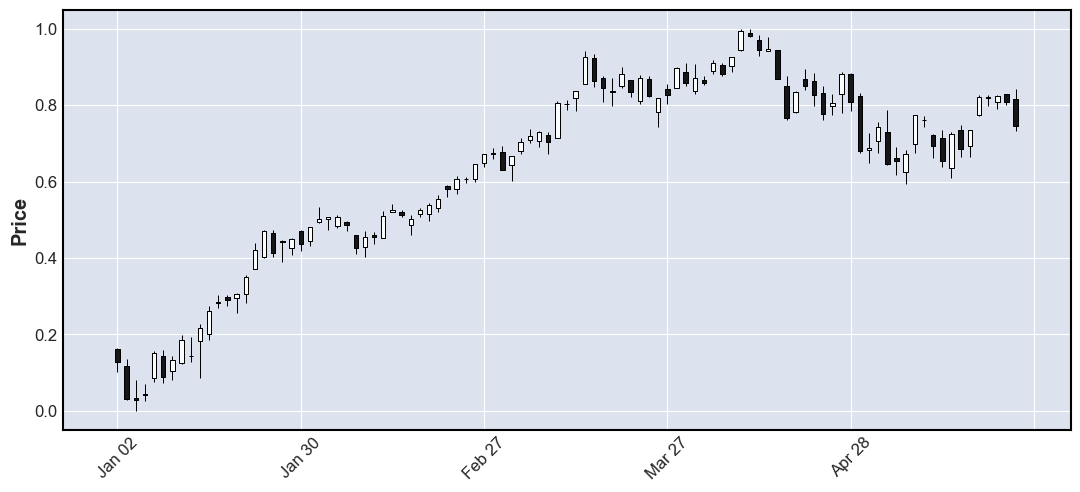

In [6]:
data['Datetime'] = pd.to_datetime(data['Date'] + ' 00:00:00', format=format)
data = data.set_index(pd.DatetimeIndex(data['Datetime']))
data = data.drop(['Date'], axis=1)
data.rename(columns={'Datetime':'Date'}, inplace=True)

mpf.plot(data, type='candle', columns=['o','h','l','c','v'], figsize=(14,6))

Encode ticks

In [7]:
encoder = CSEncoder(params).fit(data)
cse = encoder.transform(data)

2020-08-16 20:22:16 - INFO  - CSEncoder:fit                   - Fitting CS encoder to ticks read.
2020-08-16 20:22:16 - INFO  - CSEncoder:_add_ohencoder        - Adding OneHot encoders for names ['body', 'move']


Create a dataframe with the letter encoding the body, and the movement, in order to analyze it.

In [8]:
tags = pd.DataFrame([map(lambda x:x[1], cse[_]._tags()) for _ in range(len(cse))], columns=['body','do','dh','dl','dc'])
tags.head()

,body,do,dh,dl,dc
0,Q,A,A,A,A
1,Y,H,F,K,K
2,H,I,F,D,A
3,H,B,C,D,C
4,U,K,K,K,K


Plot the frequencies of the values in delta_open/high/low/close

In [9]:
def categorical_histogram(df, columns, subplot=111):
    def cat_hist(s):
        counter = Counter(s)
        z = list(zip(list(counter.keys()), counter.values()))
        z.sort(key=lambda tup: tup[0])
        return z

    ax = fig.add_subplot(subplot)
    width = (1. / len(columns))*0.8
    bin_labels = set()

    for c in columns:
        h = cat_hist(df[c])
        bins = np.arange(len(h))
        labels = [*map(lambda tup: tup[0], h)]
        heights = [*map(lambda tup: tup[1], h)]
        shift = columns.index(c) * width

        ax.bar(bins+shift, heights, width=width, label=c)
        bin_labels = bin_labels.union(set(labels))

    bin_labels = list(bin_labels)
    ax.legend(loc='best')
    ax.set_xticks(range(len(bin_labels)))
    ax.set_xticklabels(sorted(bin_labels))
    return ax

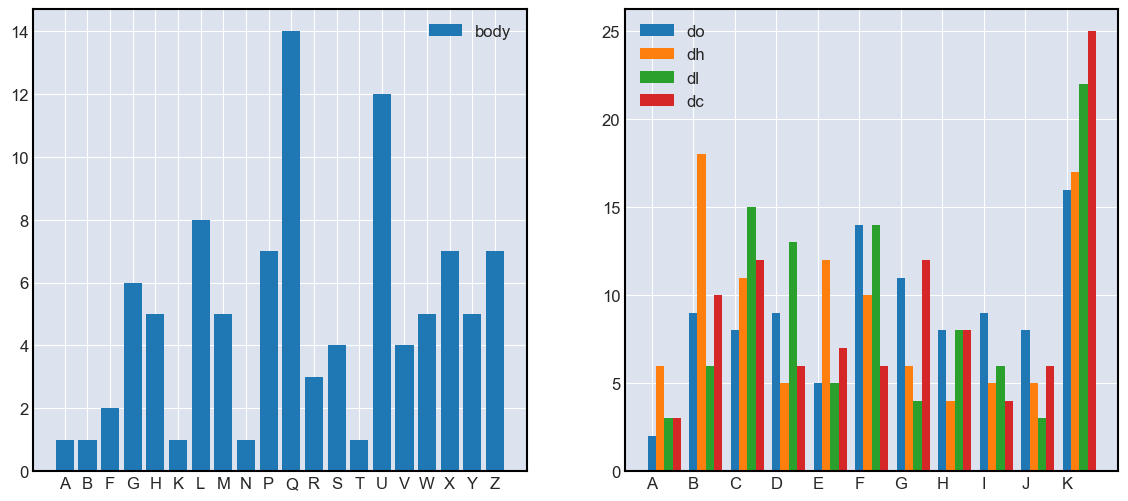

In [10]:
fig = plt.figure(figsize=(14,6))
categorical_histogram(tags, ['body'], 121).plot()
categorical_histogram(tags, ['do','dh','dl','dc'], 122).plot()
plt.show()

## Check data onehot encoded

Dataset to be feed into the LSTM is the data contained in CSE but onehot encoded and adjusted to fit the window size and the batch size.

In [11]:
dataset = predictor.prepare_input(encoder, cse, params.subtypes)

2020-08-16 20:22:16 - INFO  - Dataset:adjust                  - Adjusted dataset size from 99 -> 91
2020-08-16 20:22:16 - INFO  - Dataset:train_test_split        - Dataset split in train 72 and test 9
2020-08-16 20:22:16 - INFO  - Dataset:adjust                  - Adjusted dataset size from 99 -> 91
2020-08-16 20:22:16 - INFO  - Dataset:train_test_split        - Dataset split in train 72 and test 9


What 'dataset' looks like?

In [12]:
dataset['body'].data.iloc[0:1]

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


First row of dataset must be the $n^{th}$ row after adjusting sizes. So, $n$ must be the size of the original dataset - the size of the new one.

In [13]:
nth = data.shape[0] - dataset['body'].data.shape[0]
letters = cse[nth]._tags()[0]
print(letters)

pH


What column has a value of '1' in the first row?

In [14]:
df = dataset['body'].data.iloc[0]
column_set_to_1 = (dataset['body'].data.iloc[0] == 1.0)
dataset['body'].data.columns[column_set_to_1][0]

7

And finally, what is the order of the letter obtained in the first place? It must matches the column with a one, in the dataset.

In [15]:
ord(letters[1])-ord('A')

7

## NNs training

In [27]:
subtype = 'body'
body_lstm = CS_NN(params, None, subtype)

In [28]:
window_size = dataset[subtype].X_train.shape[1]
num_categories = dataset[subtype].X_train.shape[2]

body_lstm.build_model(window_size, num_categories)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 128)           79360     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 26)                3354      
Total params: 214,298
Trainable params: 214,298
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

body_lstm.train(dataset[subtype].X_train, dataset[subtype].y_train)

Epoch 1/530
Epoch 2/530
Epoch 3/530
Epoch 4/530
Epoch 5/530
Epoch 6/530
Epoch 7/530
Epoch 8/530
Epoch 9/530
Epoch 10/530
Epoch 11/530
Epoch 12/530
Epoch 13/530
Epoch 14/530
Epoch 15/530
Epoch 16/530
Epoch 17/530
Epoch 18/530
Epoch 19/530
Epoch 20/530
Epoch 21/530
Epoch 22/530
Epoch 23/530
Epoch 24/530
Epoch 25/530
Epoch 26/530
Epoch 27/530
Epoch 28/530
Epoch 29/530
Epoch 30/530
Epoch 31/530
Epoch 32/530
Epoch 33/530
Epoch 34/530
Epoch 35/530
Epoch 36/530
Epoch 37/530
Epoch 38/530
Epoch 39/530
Epoch 40/530
Epoch 41/530
Epoch 42/530
Epoch 43/530
Epoch 44/530
Epoch 45/530
Epoch 46/530
Epoch 47/530
Epoch 48/530
Epoch 49/530
Epoch 50/530
Epoch 51/530
Epoch 52/530
Epoch 53/530
Epoch 54/530
Epoch 55/530
Epoch 56/530
Epoch 57/530
Epoch 58/530
Epoch 59/530
Epoch 60/530
Epoch 61/530
Epoch 62/530
Epoch 63/530
Epoch 64/530
Epoch 65/530
Epoch 66/530
Epoch 67/530
Epoch 68/530
Epoch 69/530
Epoch 70/530
Epoch 71/530
Epoch 72/530
Epoch 73/530
Epoch 74/530
Epoch 75/530
Epoch 76/530
Epoch 77/530
Epoch 78

In [30]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22097), started 0:10:27 ago. (Use '!kill 22097' to kill it.)